# LAB 3

**NAME:** Aman Khoja <br>
**ID:** 9034615

In [48]:
# Import Libraries
import os
import shutil
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # type: ignore
from tensorflow.keras.applications import VGG16 # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout # type: ignore
import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore
import matplotlib.pyplot as plt

#### 1. Obtain the Data: Get the Dogs vs Cats dataset (see class' notebook, only 5000, not 25,000, images are required, these image set is defined in the notebook)

In [ ]:
# Define directories
original_dataset_dir = r'Dataset\train\train'
base_dir = r'Dataset\train'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Create training and validation directories
for category in ['cats', 'dogs']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

# Function to copy files
def copy_files(animal_type, start_idx, end_idx, target_dir):
    for i in range(start_idx, end_idx):
        fname = f'{animal_type}.{i}.jpg'
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(target_dir, animal_type + 's', fname)
        try:
            shutil.copyfile(src, dst)
        except FileNotFoundError:
            print(f"File not found: {src}")

# Copy files for training and validation datasets
copy_files('cat', 0, 2000, train_dir)
copy_files('cat', 2000, 2500, val_dir)

copy_files('dog', 0, 2000, train_dir)
copy_files('dog', 2000, 2500, val_dir)

#### 2. EDA: Explore the data with relevant graphs, statistics and insights

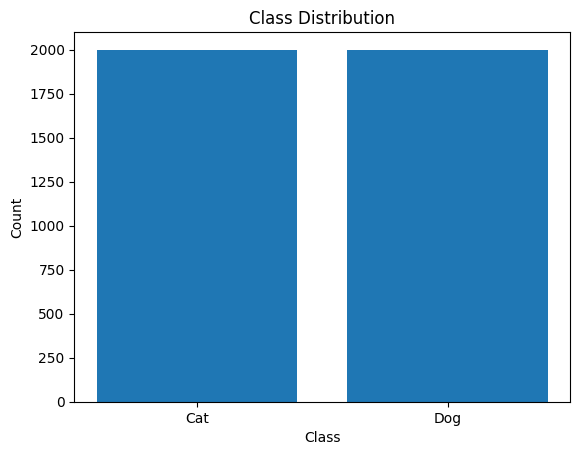

In [50]:
# Count the number of images in each class directory
cat_count = len(os.listdir(os.path.join(train_dir, 'cats')))
dog_count = len(os.listdir(os.path.join(train_dir, 'dogs')))

# Show class distribution
classes = ['Cat', 'Dog']
counts = [cat_count, dog_count]

plt.bar(classes, counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Found 4000 images belonging to 4 classes.


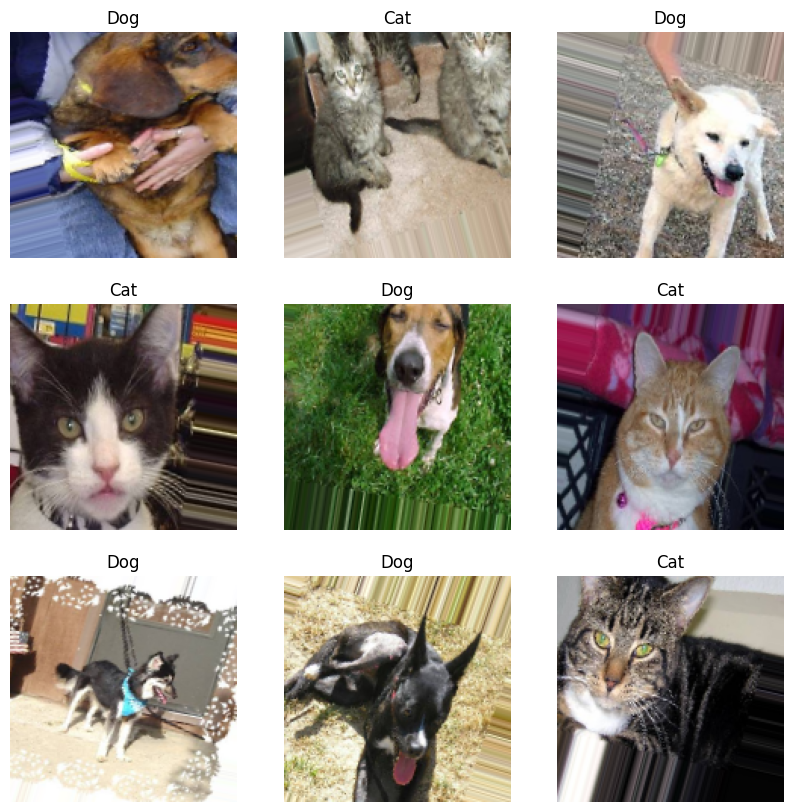

In [51]:
# Define the data generator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,  
    fill_mode='nearest'
)

# Create a data generator for the training directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Show some sample images
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i]) 
    plt.title("Dog" if labels[i] == 1 else "Cat")
    plt.axis("off")
plt.show()


3. Train two networks (use callbacks to save the best model version):
    1. Define a Neural Network of your choice (3 points)
    

In [57]:
def build_custom_cnn():
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(150, 150, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
# Build the model
model = build_custom_cnn()
# Show the model summary
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

2. Fine-Tune VGG16 (pre-trained on imagenet). Make sure to use validation to test for over-fitting. Plot the appropriate graph (3 points)

In [53]:
def build_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False  # Freeze base

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(base_model.input, x)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

# To display the model architecture
model = build_vgg16_model()
model.summary()


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

def train_model(model, model_name):
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint(f"{model_name}.h5", save_best_only=True)
    ]
    history = model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=callbacks)
    return history

# Train both models
custom_model = build_custom_cnn()
custom_history = train_model(custom_model, "custom_model")

vgg_model = build_vgg16_model()
vgg_history = train_model(vgg_model, "vgg16_model")


Found 4000 images belonging to 4 classes.
Found 1000 images belonging to 2 classes.


#### 4. Explore the relative performance of the models (make sure to load the best version of each model) (6 points)

Found 1000 images belonging to 2 classes.


C:\Users\amank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
--- Custom CNN Evaluation ---
[[ 82 418]
 [ 66 434]]


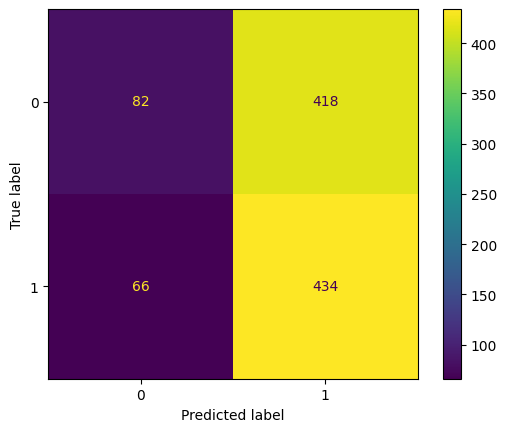

              precision    recall  f1-score   support

         Cat       0.55      0.16      0.25       500
         Dog       0.51      0.87      0.64       500

    accuracy                           0.52      1000
   macro avg       0.53      0.52      0.45      1000
weighted avg       0.53      0.52      0.45      1000

50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 536ms/step
--- VGG16 Evaluation ---
[[329 171]
 [339 161]]


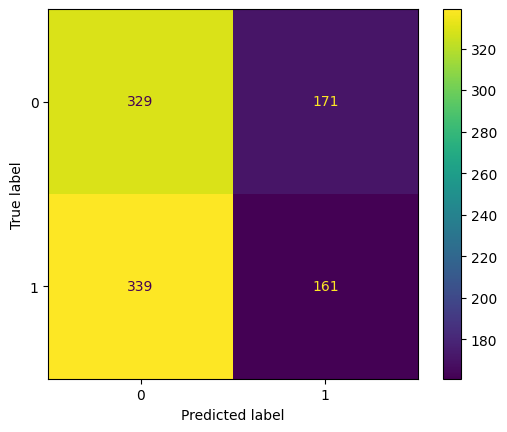

              precision    recall  f1-score   support

         Cat       0.49      0.66      0.56       500
         Dog       0.48      0.32      0.39       500

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.48      1000
weighted avg       0.49      0.49      0.48      1000



In [55]:
test_gen = val_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=20, class_mode='binary', shuffle=False)

def evaluate_model(model, name="Model"):
    predictions = model.predict(test_gen)
    y_pred = (predictions > 0.5).astype(int).ravel()
    y_true = test_gen.classes

    print(f"--- {name} Evaluation ---")
    print(confusion_matrix(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.show()
    print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

# Define the custom model
custom_model = build_custom_cnn()

# Define the VGG16 model
vgg_model = build_vgg16_model()

# Evaluate the custom model
evaluate_model(custom_model, "Custom CNN")
evaluate_model(vgg_model, "VGG16")


#### 5. Add your conclusions. (3 point)

The initial model performs with a higher accuracy rate at 51% based on its balanced categorization system yet handles categorizing "Cat" poorly. The second model generates partial accuracy by reaching 50% but completely ignores 'Cat' data while performing solely on 'Dog' data because of major underlying bias. The first model proves to be the better option since it makes efforts to maintain balanced prediction outcomes. The results can be enhanced through efforts that focus on rectifying "Cat" class imbalance through algorithm parameter adjustments or dataset re-balancing strategies and alternative algorithms and feature processing methods.